In [359]:
import numpy as np
import cvxpy as cp
import scipy as sp
from scipy.optimize import fsolve
import torch
from datetime import datetime
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib import animation
from IPython.display import Image

## Simulation Parameters

In [360]:
# dt = torch.Tensor([0.04])  # timestep
# t = torch.Tensor([2])  # duration
# m = torch.Tensor([1])  # mass
# q0 = torch.Tensor([0, 0, 1])  # init pos
# v0 = torch.Tensor([0, 0, 0])  # init vel
# v0.requires_grad = True
# force = torch.Tensor([0, 0, 0])  # init force
# g = torch.Tensor([9.8])  # gravitational acceleration
# mu = torch.Tensor([0.1])  # coefficient of friction of the plane
# normal = torch.Tensor([0, 0, 1])  # phi(q) = n @ q

In [361]:
dt = torch.Tensor([0.02])  # timestep
t = torch.Tensor([1])  # duration
m = torch.Tensor([1])  # mass
q0 = torch.Tensor([0, -4, 0.2])  # init pos
v0 = torch.Tensor([0, 20, 0.5])  # init vel
v0.requires_grad = True
force = torch.Tensor([52, 0, 0])  # init force
g = torch.Tensor([9.8])  # gravitational acceleration
mu = torch.Tensor([0.1])  # coefficient of friction of the plane
normal = torch.Tensor([0, 0, 1])  # phi(q) = n @ q

## Simulation Backend

In [362]:
class SimSystem:
    def __init__(self, q0, v0):
        self.q = q0
        self.v = v0
    
    def step_q(self, update=True):
        """ Find next q according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
        
    def step_v(self, update=True):
        """ Find next v according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
    
    def plot(self, q=None):
        """
        Generate a plot for current config (or for Q if specified)
        """
        raise NotImplementedError()
    
    @property
    def dim(self):
        return self.q.shape[0]

In [363]:
class Block2D(SimSystem):
    def __init__(self, pos, vel, mass, force, normal,
                 dt=dt, mu=mu, solver='ECOS', b_solver=0):
        super().__init__(pos, vel)
        self.m = mass
        self.f = force
        self.n = normal
        self.dt = dt
        self.t = 0
        self.mu = mu
        self.solver = solver
        self.b_solver = b_solver  # if 'eig0' or 'eig1', uses eig solver
        if self.n @ self.q <= 0:
            l = torch.ones(1)
            b = torch.ones(self.dim)
            g = torch.zeros(1)
        else:
            l = torch.zeros(1)
            b = torch.zeros(self.dim)
            g = torch.zeros(1)
        self.vlbg = torch.cat((self.v, l, b, g))
    
    def step_q(self, update=True):
        q_new = self.q + self.dt * self.v
        if update:
            self.q = q_new
            self.t += self.dt
        return q_new
    
    def step_v(self, update=True):
        v_imp, lamb = self.step_impact()
        b = self.get_b(lamb)
        #breakpoint()
        v_fric = self.v + (b + self.dt * self.f) / self.m  # self.v + self.m.inv @ (self.b - self.dt * self.f)
        v_new = torch.empty(self.dim)
        # TODO below is not general
        v_new[:-1] = v_fric[:-1]
        v_new[-1] = v_imp[-1]
        if update:
            self.v = v_new
        return v_new
    
    def step_impact(self):
        e_z = self.n.numpy()[None]
        with torch.no_grad():
            v = cp.Variable(self.dim)
            constraints = [self.dt * (self.n @ v) >= -self.n @ self.q]
            prob = cp.Problem(cp.Minimize(0.5 * self.m * cp.norm(v, 2)**2 - self.m * v @ self.v + self.dt * g * self.m * self.n @ v), constraints)
            prob.solve(solver=self.solver)
            v_new = v.value
            lamb = constraints[0].dual_value
            v_lamb = torch.Tensor(np.hstack((v_new, lamb)))
            J = torch.from_numpy(np.block([
                [lamb * self.dt.numpy() * e_z, e_z @ (self.dt.numpy() * v_new + self.q.numpy())],
                [self.m.numpy() * np.eye(self.dim), -self.dt.numpy() * e_z.T]
            ]))
        vlc = v_lamb.clone()
        # TODO does the order of subtract_val's elements matter?
        # TODO the mult by 0, 0, 1 is bc this impact calc doesn't account for the external force and so the x-y coords are off
        subtract_val = torch.cat((vlc[-1] * self.n[None] @ (self.dt * vlc[:-1] + self.q),
                                     (self.m * (vlc[:-1] - self.v) - self.dt * self.n * vlc[-1] + self.dt * self.m * (g * self.n)) * torch.Tensor([0., 0., 1.])))
        if not torch.allclose(subtract_val, torch.zeros_like(subtract_val), atol=3e-2):
            breakpoint()
        v_lamb -= subtract_val
        v_lamb.register_hook(lambda grad: torch.solve(grad[:,None], J.T.float())[0][:,0])
        v, lamb = torch.split(v_lamb, [self.dim, 1])
        return v, lamb
    
    def get_b(self, lamb):
        """
        b = argmin(v^\top v) s.t. b^\top b <= (\mu * m * g)^2. set to self.b for debugging purposes.
        """
        if self.b_solver in ['eig0', 'eig1']:
            self.b = self.get_b_eig(lamb)
        else:
            fric_bound_np = (self.mu * lamb).detach().numpy()
            b = cp.Variable(self.dim)
            constraints = [cp.norm(b, 2)**2 <= fric_bound_np**2]
            # constraints = [cp.SOC(fric_bound_np, b)]
            z = b + (self.dt * self.f).detach().numpy()
            prob = cp.Problem(cp.Minimize(cp.norm(z, 2)**2 + 2 * self.m.detach().numpy() * (z @ self.v.detach().numpy())),
                              constraints)
            prob.solve(solver=self.b_solver)
            b_new = b.value
            gamma = constraints[0].dual_value
            b_gamma = torch.Tensor(np.hstack((b_new, gamma)))
            J = torch.from_numpy(np.block([
                [(1 + gamma) * np.eye(self.dim), b_new[:,None]],
                [2 * b_new[None] * gamma, (b_new @ b_new - fric_bound_np**2)[None]]
            ]))
        bgc = b_gamma.clone()
        # TODO justified?
        offset = (self.f*self.dt + self.m*self.v).detach()
#         subtract_val = torch.cat(((1+bgc[-1])*bgc[:-1] + self.f*self.dt + self.m*self.v,
#             bgc[-1] * (bgc[:-1] @ bgc[:-1] - fric_bound_np**2)))
        subtract_val = torch.cat((self.f*self.dt + self.m*self.v - offset,
            bgc[-1] * (bgc[:-1] @ bgc[:-1] - fric_bound_np**2)))
        if not torch.allclose(subtract_val, torch.zeros_like(subtract_val), atol=3e-2):
            breakpoint()
        b_gamma -= subtract_val
        b_gamma.register_hook(lambda grad: torch.solve(grad[:, None], J.T.float())[0][:,0])
        self.b, gamma = torch.split(b_gamma, [self.dim, 1])
        return self.b

    def get_b_eig(self, lamb):
        alpha = 1  # "an arbitrary alpha > 0 (p. 10)"
        """ Interior case """
        b0 = -self.f * self.dt - self.m * self.v
        delta = self.mu * lamb # lamb is normal force; used to be self.m * g
        """ Boundary case """
        # set up generalized eigenvalue problem
        expr = (self.f * self.dt + self.m * self.v).reshape(self.dim, 1)
        if self.b_solver == 0:
            A = -torch.cat((
                torch.cat(((delta**2)[None], torch.zeros(self.dim, 1), expr)).T,
                torch.cat((torch.zeros(1, self.dim), -torch.eye(self.dim), torch.eye(self.dim))).T,
                torch.cat((expr.T, torch.eye(self.dim), torch.zeros(self.dim, self.dim))).T
            )).float()
            B = -torch.cat((
                torch.zeros(1, 1 + 2*self.dim),
                torch.cat((torch.zeros(1 + self.dim, self.dim), -torch.eye(self.dim))).T,
                torch.cat((torch.zeros(1, self.dim), -torch.eye(self.dim), torch.zeros(self.dim, self.dim))).T
            )).float()
            split_sizes = [1, self.dim, self.dim]
            sorted_largest_eig_idx = -2  # skip inf eigval
        else:
            A = torch.cat((
                torch.cat((torch.eye(self.dim), -torch.eye(self.dim))).T,
                torch.cat((-torch.eye(self.dim), (expr @ expr.T) / (delta**2))).T,
            )).float()
            B = torch.cat((
                torch.cat((torch.zeros(self.dim, self.dim), torch.eye(self.dim))).T,
                torch.cat((torch.eye(self.dim), torch.zeros(self.dim, self.dim))).T
            )).float()
            split_sizes = [0, self.dim, self.dim]
            sorted_largest_eig_idx = -1  # only finite eigvals
        # solve the generalized eigenvalue problem w/o autograd
        with torch.no_grad():
            A_np, B_np = A.detach().numpy().astype(np.float32), B.detach().numpy().astype(np.float32)
            eigvals_np, V_np = sp.linalg.eig(A, B)
            eigvals_np = eigvals_np.astype(np.float32)
            V_np = V_np.astype(np.float32)
            eigstacks = [torch.Tensor(np.hstack((V_np[:,i], eigvals_np[i]))) for i in range(len(eigvals_np))]
            J = [torch.from_numpy(np.block([
                [A_np - eigvals_np[i] * B_np, -(B_np @ V_np[:,i])[:, None]],
                [2*V_np[:,i], 0]
            ])) for i in range(len(eigvals_np))]
        for i, es in enumerate(eigstacks):
            esc = es.clone()
            subtract_val = torch.hstack((A @ esc[:-1] - esc[-1] * B @ esc[:-1], esc[:-1] @ esc[:-1] - 1))
            assert torch.allclose(subtract_val, torch.zeros_like(subtract_val), atol=3e-2)
            # reinsert gradients
            es -= subtract_val
            # register backward hook to correct for computation done outside autograd tape
            es.register_hook(lambda grad: torch.solve(grad[:,None], J[i].T.float())[0][:,0])
        V = torch.stack([es[:-1] for es in eigstacks]).T
        eigvals = torch.stack([es[-1] for es in eigstacks])
        
        sorted_eigvals = torch.argsort(eigvals)
        largest_eig_idx = sorted_eigvals[sorted_largest_eig_idx]
        second_largest_eig_idx = sorted_eigvals[sorted_largest_eig_idx-1]
        V1 = V[:, largest_eig_idx]
        lambda_max = eigvals[largest_eig_idx]
        gap = lambda_max - eigvals[second_largest_eig_idx]
        _, y1, y2 = torch.split(V1, split_sizes)
        
        # 10**-8 const from the paper, eq 4.5
        if gap == 0 or torch.linalg.norm(y1, ord=2) <= 10**-8 / torch.sqrt(gap):
            # "hard case" (§4.1 of paper)
            breakpoint()
            with torch.no_grad():
                lambda_max_np = lambda_max.detach().numpy()
                V_for_lambda_np = sp.linalg.null_space((1+lambda_max_np)*np.eye(self.dim))  # trivial unless lambda_max = -1
                V_for_lambda = torch.from_numpy(V_for_lambda_np).float()
                J = (1 + lambda_max_np) * np.eye(self.dim)
            V_for_lambda = -lambda_max * V_for_lambda  #  reinsert gradient
            V_for_lambda.register_hook(lambda grad: torch.solve(grad[:,None], J.T.float())[0][:,0])
            H = (1 + lambda_max) * torch.eye(self.dim) + alpha * V_for_lambda @ V_for_lambda.T
            q = -torch.solve(expr, H)[0]
            Vfl1 = V_for_lambda[:,0]  # can take any of the null vectors
            # b1 = q + (delta**2 - V1 @ V1 - q @ q) / (2 * q @ V1) * V1
            b1 = q + (delta**2 - q.T @ q) * Vfl1
        else:
            b1 = -torch.sign(y2 @ expr) * delta * y1 / torch.linalg.norm(y1, ord=2)  # eq 3.10 in paper
        # having found b0 and b1, pick the one with lower objective value
        objective = lambda arr: arr @ arr + 2 * (arr @ expr)
        b = b0 if (objective(b0) < objective(b1)) and (torch.linalg.norm(b0) < delta) else b1
        return b
        
    def plot(self, q=None):
        if q is None:
            q = self.q
        fig = plt.figure()
        canvas = FigureCanvas(fig)
        plt.xlim(-8, 8)
        plt.ylim(-8, 8)
        plt.plot(q[0], q[1], 'ro')
        canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return img

## Run Simulation

In [364]:
def sim(system, time=10, return_all=True):
    """
    :param system: (SimSystem) initialized obj representing system,
                    including functions to update q and v
    :param time: (float) number of seconds to simulate for
    """
    qs, vs, bs = [system.q.detach().numpy()], [system.v.detach().numpy()], []
    t = 0
#     if return_all:
#         ls = []
#         bs = []
#         gs = []
    while t < time:
        v = system.step_v()
        vs.append(v.detach().numpy())
        bs.append(system.b.detach().numpy())  # calculated while stepping v
        q = system.step_q()
        qs.append(q.detach().numpy())
        t += system.dt
    return np.stack(qs) if not return_all else\
            (np.stack(qs), np.stack(vs), np.stack(bs))

In [365]:
system = Block2D(q0, v0, m, force, normal, dt, solver='ECOS', b_solver='ECOS')
qs, vs, bs = sim(system, time=t)

/Users/sanjeev/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Plot

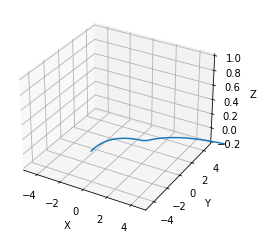

In [366]:
Writer = animation.writers['pillow']
writer = Writer(fps=int(1/dt), bitrate=600)

def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])

fig = plt.figure()
ax = fig.gca(projection='3d')
line, = ax.plot(qs[:1, 0], qs[:1, 1], qs[:1, 2])
ax.set_xlim3d([-5, 5])
ax.set_xlabel('X')
ax.set_ylim3d([-5, 5])
ax.set_ylabel('Y')
ax.set_zlim3d([-0.2, 1])
ax.set_zlabel('Z')
ani = animation.FuncAnimation(fig, update, int(t / dt), fargs=(qs.T, line), interval=dt, blit=False)
time = datetime.now().strftime('%m%d%y_%H%M%S')
filename = f'gifs/impact/sim2d_impact_{time}.gif'
ani.save(filename, writer=writer)

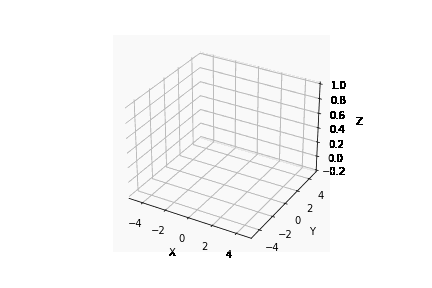

In [367]:
Image(filename=filename)

In [368]:
qs

array([[ 0.00000000e+00, -4.00000000e+00,  2.00000003e-01],
       [ 2.07999684e-02, -3.60000062e+00,  2.06085920e-01],
       [ 6.23998754e-02, -3.20000172e+00,  2.08257779e-01],
       [ 1.24799691e-01, -2.80000353e+00,  2.06515759e-01],
       [ 2.07999378e-01, -2.40000582e+00,  2.00860128e-01],
       [ 3.11998904e-01, -2.00000882e+00,  1.91290930e-01],
       [ 4.36798334e-01, -1.60001206e+00,  1.77806735e-01],
       [ 5.82397699e-01, -1.20001543e+00,  1.60402805e-01],
       [ 7.48796880e-01, -8.00019264e-01,  1.39074013e-01],
       [ 9.35995579e-01, -4.00024146e-01,  1.13816775e-01],
       [ 1.14399207e+00, -3.32295895e-05,  8.46886039e-02],
       [ 1.37278759e+00,  3.99956048e-01,  5.16218506e-02],
       [ 1.62238300e+00,  7.99944997e-01,  1.46506391e-02],
       [ 1.81945908e+00,  1.09147072e+00,  1.70432031e-07],
       [ 1.98163581e+00,  1.30846953e+00,  2.08180523e-07],
       [ 2.15191698e+00,  1.51041186e+00,  4.95703603e-08],
       [ 2.32952356e+00,  1.69811368e+00